<a href="https://colab.research.google.com/github/Antony-gitau/machine_learning_playground/blob/main/ViT_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"remain curious whilst building the fundamental skills of turning math and words on a page into working code."

this notebook is a replication of the vision transformer paper with the guidances of this [tutorial](https://www.learnpytorch.io/08_pytorch_paper_replicating/).



In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 27.48 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data
so after loading the tools we need to work the replication, its now time to access the data.

we use the download data function in the helper file to get the data from the github page and save it to a folder of our choice in the drive.

we then care about preparing data in a format similiar to the ViT paper.
- like image size
- batch size

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c5f3da69c00>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

An iterator is an object that allows us to traverse through all the elements of a collection (like lists, tuples, etc.) or, in this case, the batches in the train_dataloader. The iter() function is implicitly called when a loop is initiated, but here it is being called explicitly.

When you apply next() to the iterator of train_dataloader, it fetches the next available batch from the DataLoader.

This is a common pattern in PyTorch for iterating through a dataset batch by batch, especially when the size of the entire dataset makes it impractical to load all at once into memory.

In [10]:
#just playing with the plots by changing the image and label accordingly to see the changes
image_2 = image_batch[10]
label_2 = label_batch[10]

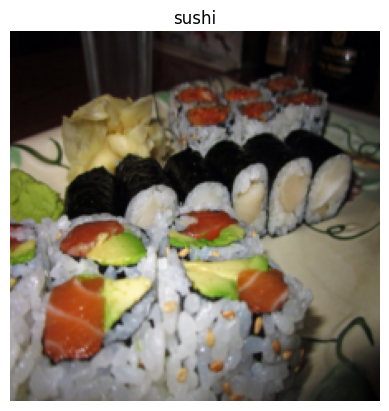

In [11]:
# Plot image with matplotlib
plt.imshow(image_2.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label_2])
plt.axis(False);

The goal of replication is to convert all the layers, blocks, that make up an architecture into a function python code.

for ViT
- Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
- Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding,
- Layer norms for regularization
- MSA
- MLP  - collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method).
- Transformer encoder
- MLP head

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

we will start by reproducing the smallest/easiest to reproduce parts of the model



In [12]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")


# Input shape (this is the size of a single image before it has been reshaped as described in section 3.1 in the paper)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape of the image after reshaping has been done
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


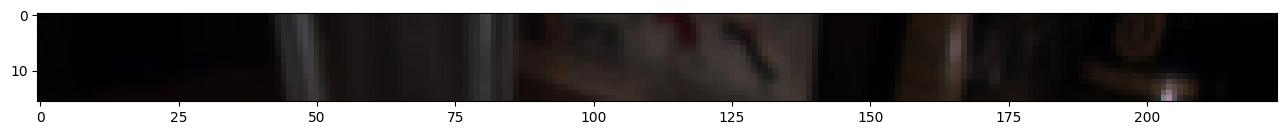

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image_2.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


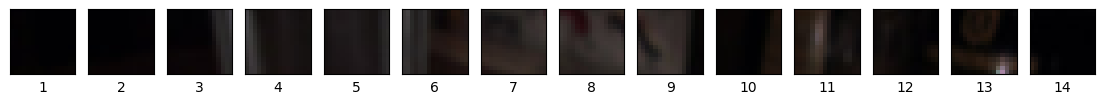

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

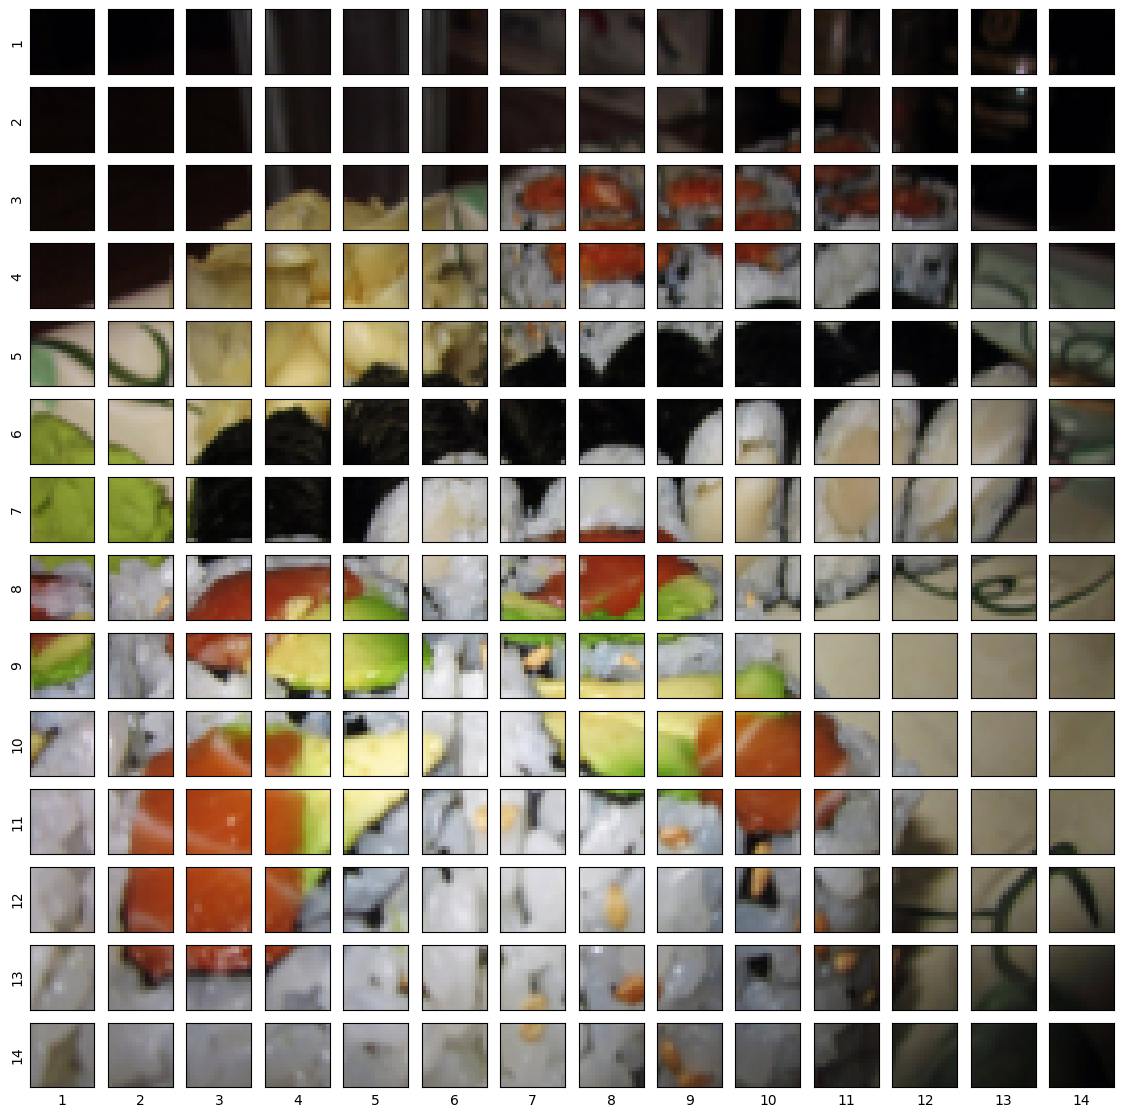

In [15]:
# creating patches from an input image
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0

fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True
                        )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    axs[i, j].set_ylabel(i+1)
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()



The above operation, we just implemented a patch on single image. this mean that we took an image and iterated on its height and width and the created patches on it,

now we want to implement CNN feature maps.This means that we want to convert an input 2d of an image into 1d flattened image.

lets try

In [21]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use
                   stride=patch_size,
                   padding=0)

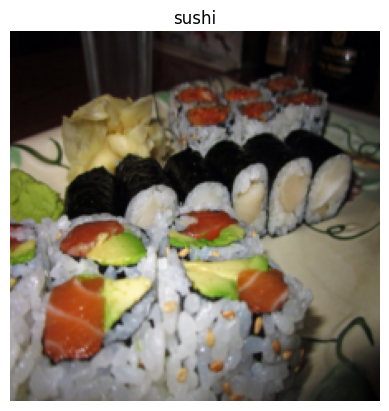

In [23]:
# View single image
plt.imshow(image_2.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label_2])
plt.axis(False);

### Creating image patches with torch.nn.Conv2d()

- we want to move from a 2d input image to a 1d learnable feature map that will be feed to the transformer encoder.

In [24]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image_2.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

showing random cnn feature maps from these indexes:  [5, 493, 421, 409, 19, 470, 716, 215, 211, 503]


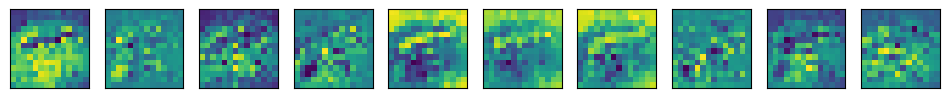

In [33]:
import random
random_indices = random.sample(range(0, 768), k=10)
print(f"showing random cnn feature maps from these indexes: ", random_indices)

fig, axs = plt.subplots(nrows=1, ncols = 10, figsize=(12,12))

for i, idx in enumerate(random_indices):
  image_comv_featuremap = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_comv_featuremap.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[],xticks=[],yticks=[])


In [38]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0313, -0.0314,  0.0073,  0.0324,  0.0232,  0.0351,  0.0485,
            0.0292,  0.0207, -0.0135,  0.0649, -0.0142,  0.0488, -0.0425],
          [-0.0190, -0.0192,  0.0039,  0.0555,  0.0147,  0.0488,  0.0182,
            0.0288,  0.0355, -0.0411,  0.0028,  0.0060,  0.0023, -0.0337],
          [-0.0107, -0.0072,  0.0191,  0.1412,  0.0807,  0.1040,  0.1641,
            0.1730,  0.0785,  0.1227,  0.0207, -0.0191, -0.0509, -0.0291],
          [-0.0098, -0.0645,  0.2388,  0.2839,  0.2610,  0.2903,  0.1240,
            0.0749,  0.0782,  0.2758,  0.2306,  0.1765,  0.1037,  0.0486],
          [ 0.2273,  0.3082,  0.2893,  0.3565,  0.3544,  0.3110,  0.1519,
            0.2535,  0.0833, -0.0252, -0.0353, -0.0611,  0.0064,  0.1067],
          [ 0.3961,  0.3142,  0.2541,  0.0853, -0.0262, -0.0517, -0.0179,
           -0.0534, -0.0576,  0.1776,  0.2769,  0.2147,  0.2597,  0.0937],
          [ 0.2667,  0.3819,  0.0242, -0.0251, -0.0064,  0.3713,  0.2569,
            0.3732,  0.3041,  0.

In [39]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the feature_map_height and feature_map_width dimensions of image_out_of_conv.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


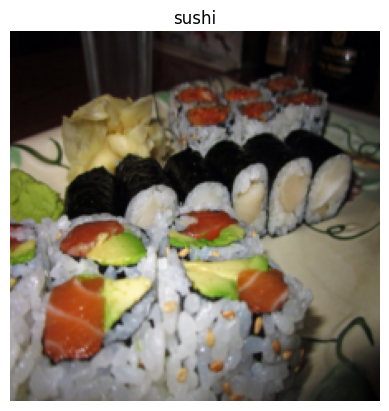

In [40]:
# 1. View single image
plt.imshow(image_2.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label_2])
plt.axis(False);
print(f"Original image shape: {image_2.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image_2.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [44]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


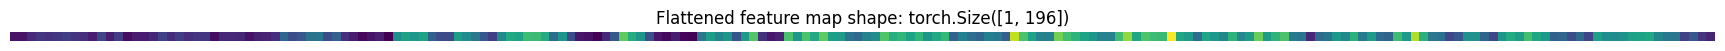

In [50]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [51]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0313, -0.0314,  0.0073,  0.0324,  0.0232,  0.0351,  0.0485,  0.0292,
           0.0207, -0.0135,  0.0649, -0.0142,  0.0488, -0.0425, -0.0190, -0.0192,
           0.0039,  0.0555,  0.0147,  0.0488,  0.0182,  0.0288,  0.0355, -0.0411,
           0.0028,  0.0060,  0.0023, -0.0337, -0.0107, -0.0072,  0.0191,  0.1412,
           0.0807,  0.1040,  0.1641,  0.1730,  0.0785,  0.1227,  0.0207, -0.0191,
          -0.0509, -0.0291, -0.0098, -0.0645,  0.2388,  0.2839,  0.2610,  0.2903,
           0.1240,  0.0749,  0.0782,  0.2758,  0.2306,  0.1765,  0.1037,  0.0486,
           0.2273,  0.3082,  0.2893,  0.3565,  0.3544,  0.3110,  0.1519,  0.2535,
           0.0833, -0.0252, -0.0353, -0.0611,  0.0064,  0.1067,  0.3961,  0.3142,
           0.2541,  0.0853, -0.0262, -0.0517, -0.0179, -0.0534, -0.0576,  0.1776,
           0.2769,  0.2147,  0.2597,  0.0937,  0.2667,  0.3819,  0.0242, -0.0251,
          -0.0064,  0.3713,  0.2569,  0.3732,  0.3041,  0.3968,  0.2829,  0.2733,
           0.168

## single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).